# GPT-5 Prompt Migration and Improvement using the new prompt optimizer

The GPT-5 Family of models are the smartest models we’ve released to date, representing a step change in the models’ capabilities across the board. GPT-5 is particularly specialized in agentic task performance, coding, and steerability, making it a great fit for everyone from curious users to advanced researchers. 

GPT-5 will benefit from all the traditional [prompting best practices](https://cookbook.openai.com/examples/gpt-5/gpt-5_prompting_guide), but to make optimizations and migrations easier, we are introducing the **[GPT-5  Prompt Optimizer](https://platform.openai.com/chat/edit?optimize=true)** in our Playground to help users get started on **improving existing prompts** and **migrating prompts** for GPT-5 and other OpenAI models.

![Prompt Optimizer demo](../../images/prompt-optimizer-3-22s.gif)

In this cookbook we will show you how to use the Prompt Optimzer to get spun up quickly to solve your tasks with GPT-5, while demonstrating how prompt optimize can have measurable improvements. 

### Migrating and Optimizing Prompts

Crafting effective prompts is a critical skill when working with LLMs. The goal of the Prompt Optimizer is to give your prompt the best practices and formatting most effective for our models. The Optimizer also removes common prompting failure modes such as:  

•   Contradictions in the prompt instructions  
•	Missing or unclear format specifications  
•	Inconsistencies between the prompt and few-shot examples  

Along with tuning the prompt for the target model, the Optimizer is cognizant of the specific task you are trying to accomplish and can apply crucial practices to boost performance in Agentic Workflows, Coding and Multi-Modality. Let's walk through some before-and-afters to see where prompt optimization shines. 

> Remember that prompting is not a one-size-fits-all experience, so we recommend running thorough experiments and iterating to find the best solution for your problem.


> Ensure you have set up your OpenAI API Key set as `OPENAI_API_KEY` and have access to GPT-5


In [1]:
import os

required = ('OPENAI_API_KEY',)
missing = [k for k in required if not os.getenv(k)]
print('OPENAI_API_KEY is set!' if not missing else 'Missing environment variable: ' + ', '.join(missing) + '. Please set them before running the workflow.')


OPENAI_API_KEY is set!


In [ ]:
## Let's install our required packages
%pip install -r requirements.txt --quiet

----------------


### Coding and Analytics: Streaming Top‑K Frequent Words 

We start with a task in a field that model has seen significant improvements: Coding and Analytics. We will ask the model to generate a Python script that computes the exact Top‑K most frequent tokens from a large text stream using a specific tokenization spec. Tasks like these are highly sensitive to poor prompting as they can push the model toward the wrong algorithms and approaches (approximate sketches vs multi‑pass/disk‑backed exact solutions), dramatically affecting accuracy and runtime.

For this task, we will evaluate:
1. Compilation/Execution success over 30 runs
2. Average runtime (successful runs)
3. Average peak memory (successful runs)
4. Exactness: output matches ground‑truth Top‑K with tie‑break: by count desc, then token asc

Note: Evaluated on an M4 Max MacBook Pro; adjust constraints if needed.


### Our Baseline Prompt
For our example, let's look at a typical starting prompt with some minor **contradictions in the prompt**, and **ambiguous or underspecified instructions**. Contradictions in instructions often reduce performance and increase latency, especially in reasoning models like GPT-5, and ambiguous instructions can cause unwanted behaviors. 

In [4]:
baseline_prompt = """
Write Python to solve the task on a MacBook Pro (M4 Max). Keep it fast and lightweight.

- Prefer the standard library; use external packages if they make things simpler.
- Stream input in one pass to keep memory low; reread or cache if that makes the solution clearer.
- Aim for exact results; approximate methods are fine when they don't change the outcome in practice.
- Avoid global state; expose a convenient global like top_k so it's easy to check.
- Keep comments minimal; add brief explanations where helpful.
- Sort results in a natural, human-friendly way; follow strict tie rules when applicable.

Output only a single self-contained Python script inside one Python code block, with all imports, ready to run.
"""


This baseline prompt is something that you could expect from asking ChatGPT to write you a prompt, or talking to a friend who is knowledgeable about coding but not particularly invested in your specific use case. Our baseline prompt is intentionally shorter and friendlier, but it hides mixed signals that can push the model into inconsistent solution families.

First, we say to prefer the standard library, then immediately allow external packages “if they make things simpler.” That soft permission can nudge the model toward non‑portable dependencies or heavier imports that change performance and even execution success across environments.

Next, we encourage single‑pass streaming to keep memory low, but we also say it’s fine to reread or cache “if that makes the solution clearer.” That ambiguity opens the door to multi‑pass designs or in‑memory caches that defeat the original streaming constraint and can alter runtime and memory profiles.

We also ask for exact results while permitting approximate methods “when they don’t change the outcome in practice.” This is a judgment call the model can’t reliably verify. It may introduce sketches or heuristics that subtly shift counts near the Top‑K boundary, producing results that look right but fail strict evaluation.

We advise avoiding global state, yet suggest exposing a convenient global like `top_k`. That mixes interface contracts: is the function supposed to return data, or should callers read globals? Models may implement both, causing side effects that complicate evaluation and reproducibility.

Documentation guidance is similarly split: “keep comments minimal” but “add brief explanations.” Depending on how the model interprets this, you can get under‑explained code or prose interleaved with logic, which sometimes leaks outside the required output format.

Finally, we ask for “natural, human‑friendly” sorting while also mentioning strict tie rules. These aren’t always the same. The model might pick convenience ordering (e.g., `Counter.most_common`) and drift from the evaluator’s canonical `(-count, token)` sort, especially on ties—leading to subtle correctness misses.

**Why this matters**: the softened constraints make the prompt feel easy to satisfy, but they create forks in the road. The model may pick different branches across runs—stdlib vs external deps, one‑pass vs reread/cache, exact vs approximate—yielding variability in correctness, latency, and memory.

**Our evaluator remains strict**: fixed tokenization `[a-z0-9]+` on lowercased text and deterministic ordering by `(-count, token)`. Any divergence here will penalize exactness even if the rest of the solution looks reasonable.


### Let's see how it performs: Generating 30 code scripts with the baseline prompt 

Using the OpenAI Responses API we'll invoke the model 30 times with our baseline prompt and save each response as a Python file in the `results_topk_baseline`. This may take some time. 


In [ ]:
from scripts.gen_baseline import generate_baseline_topk

MODEL = "gpt-5"
N_RUNS = 30
CONCURRENCY = 10
OUTPUT_DIR = "results_topk_baseline"

USER_PROMPT = """
Task:
Given globals text (str) and k (int), produce the Top-K most frequent tokens.

Tokenization:
- Case-insensitive tokenization using an ASCII regex; produce lowercase tokens. Whole-string lowercasing is not required.
- Tokens are ASCII [a-z0-9]+ sequences; treat all other characters as separators.

Output:
- Define top_k as a list of (token, count) tuples.
- Sort by count desc, then token asc.
- Length = min(k, number of unique tokens).

Notes:
- Run as-is with the provided globals; no file or network I/O.
"""

generate_baseline_topk(
    model=MODEL,
    n_runs=N_RUNS,
    concurrency=CONCURRENCY,
    output_dir=OUTPUT_DIR,
    dev_prompt=baseline_prompt,
    user_prompt=USER_PROMPT,
)



### Evaluate Generated Scripts - Baseline Prompt

We then benchmark every script in ``results_topk_baseline`` On larger datasets this evaluation is intentionally heavy and can take several minutes.

In [ ]:
from scripts.topk_eval import evaluate_folder

evaluate_folder(
    folder_path="results_topk_baseline",
    k=500,
    scale_tokens=5_000_000,
    csv_path="run_results_topk_baseline.csv",
)



### Optimizing our Prompt 

Now let's use the prompt optimization tool in the console to improve our prompt and then review the results. We can start by going to the [OpenAI Optimize Playground](https://platform.openai.com/chat/edit?optimize=true), and pasting our existing prompt in the Developer Message section.

From there press the **Optimize** button. This will open the optimization panel. At this stage, you can either provide specific edits you'd like to see reflected in the prompt or simply press **Optimize** to have it refined according to best practices for the target model and task. To start let's do just this.

![optimize_image](../../images/image_optimize_1.png)



Once it's completed you'll see the result of the prompt optimization. In our example below you'll see many changes were made to the prompt. It will also give you snippets of what it changed and why the change was made. You can interact with these by opening the comments up or using the inline reviewer mode.

We'll add an additional change we'd like which include:

- Enforcing the single-pass streaming

This is easy using the iterative process of the Prompt Optimizer.

![optimize_image](../../images/image_optimize_2.png)



Once we are happy with the optimized version of our prompt, we can save it as a [Prompt Object](#https://platform.openai.com/docs/guides/prompt-engineering#reusable-prompts) using a button on the top right of the optimizer. We can use this object within our API Calls which can help with future iteration, version management, and reusability across different applications.  

![optimize_image](../../images/image_optimize_3.png)


###  Let's see how it performs: Evaluating our improved prompt 

For visibility we will provide our new optimized prompt here, but you can also pass the ``prompt_id`` and ``version``. Let's start by writing out our optimized prompt. 

In [18]:
optimized_prompt = """
# Objective
Generate a single, self-contained Python script that exactly solves the specified task on a MacBook Pro (M4 Max).

# Hard requirements
- Use only Python stdlib. No approximate algorithms.
- Tokenization: ASCII [a-z0-9]+ on the original text; match case-insensitively and lowercase tokens individually. Do NOT call text.lower() on the full string.
- Exact Top‑K semantics: sort by count desc, then token asc. No reliance on Counter.most_common tie behavior.
- Define `top_k` as a list of (token, count) tuples with length = min(k, number of unique tokens).
- When globals `text` (str) and `k` (int) exist, do not reassign them; set `top_k` from those globals. If you include a `__main__` demo, guard it to run only when globals are absent.
- No file I/O, stdin, or network access, except optionally printing `top_k` as the last line.

# Performance & memory constraints
- Do NOT materialize the entire token stream or any large intermediate list.
- Do NOT sort all unique (token, count) items unless k >= 0.3 * number_of_unique_tokens.
- When k < number_of_unique_tokens, compute Top‑K using a bounded min‑heap of size k over counts.items(), maintaining the correct tie-break (count desc, then token asc).
- Target peak additional memory beyond the counts dict to O(k). Avoid creating `items = sorted(counts.items(), ...)` for large unique sets.

# Guidance
- Build counts via a generator over re.finditer with re.ASCII | re.IGNORECASE; lowercase each matched token before counting.
- Prefer heapq.nsmallest(k, cnt.items(), key=lambda kv: (-kv[1], kv[0])) for exact selection without full sort; avoid heapq.nlargest.
- Do NOT wrap tokens in custom comparator classes (e.g., reverse-lex __lt__) or rely on tuple tricks for heap ordering.
- Keep comments minimal; include a brief complexity note (time and space).

# Output format
- Output only one Python code block; no text outside the block.

# Examples 
```python
import re, heapq
from collections import Counter
from typing import List, Tuple, Iterable

_TOKEN = re.compile(r"[a-z0-9]+", flags=re.ASCII | re.IGNORECASE)

def _tokens(s: str) -> Iterable[str]:
    # Case-insensitive match; lowercase per token to avoid copying the whole string
    for m in _TOKEN.finditer(s):
        yield m.group(0).lower()

def top_k_tokens(text: str, k: int) -> List[Tuple[str, int]]:
    if k <= 0:
        return []
    cnt = Counter(_tokens(text))
    u = len(cnt)
    key = lambda kv: (-kv[1], kv[0])
    if k >= u:
        return sorted(cnt.items(), key=key)
    # Exact selection with bounded memory
    return heapq.nsmallest(k, cnt.items(), key=key)

# Compute from provided globals when available; demo only if missing and running as main
try:
    text; k  # type: ignore[name-defined]
except NameError:
    if __name__ == "__main__":
        demo_text = "A a b b b c1 C1 c1 -- d! d? e"
        demo_k = 3
        top_k = top_k_tokens(demo_text, demo_k)
        print(top_k)
else:
    top_k = top_k_tokens(text, k)  # type: ignore[name-defined]
# Complexity: counting O(N tokens), selection O(U log k) via heapq.nsmallest; extra space O(U + k)
```
"""


### Generating 30 code scripts with the Optimized prompt

In [ ]:
from scripts.gen_optimized import generate_optimized_topk

MODEL = "gpt-5"
N_RUNS = 30
CONCURRENCY = 10
OUTPUT_DIR = "results_topk_optimized"

USER_PROMPT = """
Task:
Given globals text (str) and k (int), produce the Top-K most frequent tokens.

Tokenization:
- Case-insensitive tokenization using an ASCII regex; produce lowercase tokens. Whole-string lowercasing is not required.
- Tokens are ASCII [a-z0-9]+ sequences; treat all other characters as separators.

Output:
- Define top_k as a list of (token, count) tuples.
- Sort by count desc, then token asc.
- Length = min(k, number of unique tokens).

Notes:
- Run as-is with the provided globals; no file or network I/O.
"""

generate_optimized_topk(
    model=MODEL,
    n_runs=N_RUNS,
    concurrency=CONCURRENCY,
    output_dir=OUTPUT_DIR,
    dev_prompt=optimized_prompt,
    user_prompt=USER_PROMPT,
)


### Evaluate Generated Scripts - Optimized Prompt

We run the same evaluation as above, but now with our optimized prompt to see if there were any improvements

In [ ]:
from scripts.topk_eval import evaluate_folder

evaluate_folder(
    folder_path="results_topk_optimized",
    k=500,
    scale_tokens=5_000_000,
    csv_path="run_results_topk_optimized.csv",
)


### Adding LLM-as-a-Judge Grading 

Along with more quantitative evaluations we can measure the models performance on more qualitative metrics like code quality, and task adherence. We have created a sample prompt for this called ``llm_as_judge.txt``. 

In [21]:
from scripts.llm_judge import judge_folder

In [ ]:

# Run LLM-as-judge for baseline results
judge_folder(
    results_dir="results_topk_baseline",
    out_dir=None,  # auto-map to results_llm_as_judge_baseline
    model="gpt-5",
    system_prompt_path="llm_as_judge.txt",
    task_text=None,  # use default task description
    concurrency=6,
)


In [ ]:

# Run LLM-as-judge for optimized results
judge_folder(
    results_dir="results_topk_optimized",
    out_dir=None,  # auto-map to results_llm_as_judge_optimized
    model="gpt-5",
    system_prompt_path="llm_as_judge.txt",
    task_text=None,
    concurrency=6,
)



### Summarizing the results 

We can now demonstrate from both a quantitative standpoint, along with a qualitative standpoint from our LLM as Judge results. 

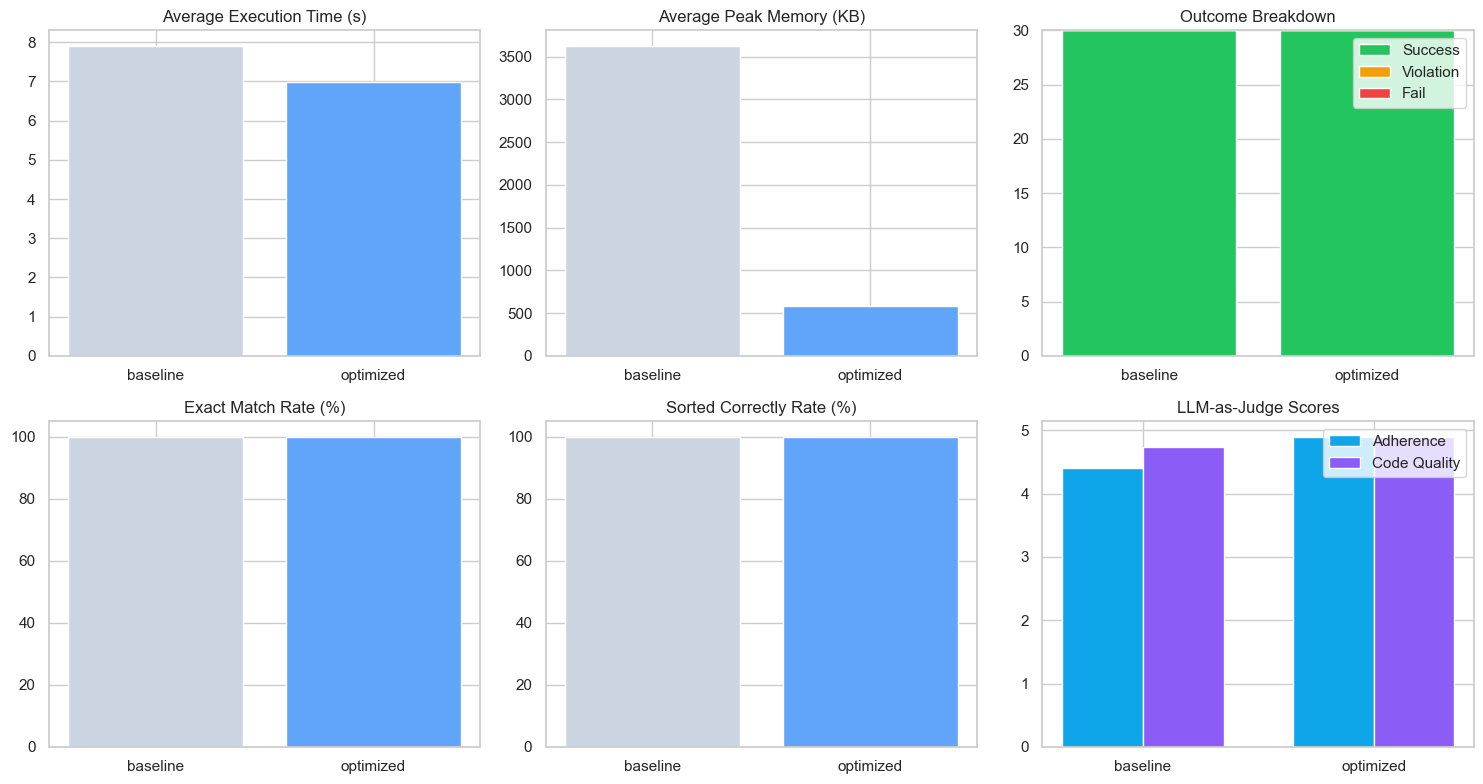

### Prompt Optimization Results - Coding Tasks

| Metric                      | Baseline | Optimized | Δ (Opt − Base) |
|----------------------------|---------:|----------:|---------------:|
| Avg Time (s)                |    7.906 |     6.977 |        -0.929 |
| Peak Memory (KB)            |   3626.3 |     577.5 |       -3048.8 |
| Exact (%)                   |    100.0 |     100.0 |           0.0 |
| Sorted (%)                  |    100.0 |     100.0 |           0.0 |
| LLM Adherence (1–5)         |     4.40 |      4.90 |         +0.50 |
| Code Quality (1–5)          |     4.73 |      4.90 |         +0.16 |

### Prompt Optimization Results - Coding Tasks

| Metric                      | Baseline | Optimized | Δ (Opt − Base) |
|----------------------------|---------:|----------:|---------------:|
| Avg Time (s)                |    7.906 |     6.977 |        -0.929 |
| Peak Memory (KB)            |   3626.3 |     577.5 |       -3048.8 |
| Exact (%)                   |    100.0 |     100.0 |           0.0 |
| Sorted (%)                  |    100.0 |     100.0 |           0.0 |
| LLM Adherence (1–5)         |     4.40 |      4.90 |         +0.50 |
| Code Quality (1–5)          |     4.73 |      4.90 |         +0.16 |


In [6]:
from pathlib import Path
import importlib
import scripts.results_summarizer as rs
from IPython.display import Markdown, display

importlib.reload(rs)

fig = rs.render_charts(
    quant_baseline=Path("results_topk_baseline")/"run_results_topk_baseline.csv",
    quant_optimized=Path("results_topk_optimized")/"run_results_topk_optimized.csv",
    judge_baseline=Path("results_llm_as_judge_baseline")/"judgement_summary.csv",
    judge_optimized=Path("results_llm_as_judge_optimized")/"judgement_summary.csv",
    auto_display=True,
    close_after=True,
)
md = rs.build_markdown_summary(
    quant_baseline=Path("results_topk_baseline")/"run_results_topk_baseline.csv",
    quant_optimized=Path("results_topk_optimized")/"run_results_topk_optimized.csv",
    judge_baseline=Path("results_llm_as_judge_baseline")/"judgement_summary.csv",
    judge_optimized=Path("results_llm_as_judge_optimized")/"judgement_summary.csv",
)

display(Markdown(md))

print(md)

Even though GPT-5 already produced correct code, prompt optimization tightened constraints and clarified any ambiguity. Showing overall improvements to the results!




--------------------------------------------------------------------

### Context and Retrieval: Simulating a Financial Question Answering

Most production use cases face imperfect queries and noisy context. **FailSafeQA** is an excellent benchmark that deliberately perturbs both the **query** (misspellings, incompleteness, off-domain phrasing) and the **context** (missing, OCR-corrupted, or irrelevant docs) and reports **Robustness**, **Context Grounding**, and **Compliance**—i.e., can the model answer when the signal exists and abstain when it doesn’t.

![FailSafeQA diagram](../../images/image_optimize_4.png)

**Links**
- Paper (arXiv): *Expect the Unexpected: FailSafe Long Context QA for Finance* — https://arxiv.org/abs/2502.06329  
- Dataset (Hugging Face): https://huggingface.co/datasets/Writer/FailSafeQA  
- Authors/Makers: Kiran Kamble, Melisa Russak, Dmytro Mozolevskyi, Muayad Ali, Mateusz Russak, Waseem AlShikh (Writer.ai) — see author list on the arXiv page above


We will run FailSafeQA evaluations via the helper script and compare Baseline vs Optimized prompts side by side.

In [3]:
# Define the Baseline FailSafeQA system prompt here for reuse
baseline_prompt_fsqa = (
    "You are a finance QA assistant. Answer ONLY using the provided context.\n"
    "If the context is missing or irrelevant, politely refuse and state that you need the relevant document."
)

We can use the prompt optimizer once again to construct a new prompt that is more suitable for this use case. Drawing on best practices for long-context question answering, we know that we should remind our answer model to rely on information in the context section and refuse answers to questions if the context is insufficient. By using the Optimize button once without any arguments we get a reasonable structure for the prompt and end up with this as our optimized prompt.


![optimize_image](../../images/image_optimize_5.png)



In [4]:
optimized_fsqa_prompt = """You are a finance document QA assistant.

Behavioral priorities (in order):
1) Grounding: Use ONLY the text inside [Context]. Do NOT use outside knowledge or assumptions.
2) Evidence check: Before answering, verify that the answer text (numbers, entities, dates, phrasing) is explicitly present or directly entailed by [Context]. If not, refuse (see Refusal policy).
3) Robustness to query noise: The user question may contain misspellings, missing words, or non-financial phrasing. Infer intent using the context and answer if the meaning is clear and supported by the context.
4) OCR noise handling: The context may include OCR artifacts (repeated characters, stray symbols, broken words). Ignore junk characters and reconstruct meaning when the underlying sentence is still recoverable. Do not guess beyond what the context supports.

Refusal policy:
- If [Context] is empty or lacks the information to answer, reply with a brief refusal and guidance. Do NOT attempt a general-knowledge answer.
- If the question is unrelated to the content of [Context] (out of scope), reply with a brief refusal and guidance. Do NOT speculate.
- If the question is incomplete but the correct answer is unambiguous from [Context], infer the intent and answer exactly; do NOT refuse.

Answer style:
- Default to the **shortest exact answer** needed to satisfy the question (e.g., the precise number/string/date as written). Preserve units, signs, casing, currency symbols, commas, and parentheses from the context. Do NOT round numbers unless asked.
- If the user explicitly asks to “write”, “draft”, or “generate” content, you may produce multi-sentence or formatted text—but still source every factual claim strictly from [Context].
- If the question is ambiguous, state the needed clarification in one short sentence, then provide the best supported answer if possible.

Output format:
- If answerable from the context:
  FINAL: <exact answer here>
  (optional) EVIDENCE: "<very short quoted span from the context that contains the answer>"
- If refusing:
  FINAL: Insufficient information in the provided context to answer this question. Please upload the relevant document or refine your question to include the necessary details."""

Let's now run our evaluations, for demonstration we will display the results of a single comparison, but you can also run the full evaluation. Note: This will take time.

In [ ]:
import importlib
import run_FailSafeQA
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

# Ensure latest function signature is used after code edits
importlib.reload(run_FailSafeQA)
run_failsafeqa = run_FailSafeQA.run_failsafeqa

# Set idx to an integer for a quick single-example comparison; set to None for full run
idx = 0  # e.g., 0 for a single datapoint

#Helper functions:
class OpenAIAnswer:
    def __init__(self):
        self.client = OpenAI()

    def __call__(self, system_prompt: str, user_prompt: str, model: str) -> str:
        resp = self.client.responses.create(
            model=model,
            input=[
                {"role": "developer", "content": [{"type": "input_text", "text": system_prompt}]},
                {"role": "user", "content": [{"type": "input_text", "text": user_prompt}]},
            ],
            text={"format": {"type": "text"}, "verbosity": "medium"},
            reasoning={"effort": "medium", "summary": "auto"},
            tools=[],
        )
        return resp.output_text
class OpenAIJudge:
    def __init__(self):
        self.client = OpenAI()

    def __call__(self, prompt: str, model: str) -> str:
        resp = self.client.responses.create(
            model=model,
            input=[{"role": "user", "content": [{"type": "input_text", "text": prompt}]}],
            text={"format": {"type": "text"}, "verbosity": "medium"},
            reasoning={"effort": "medium", "summary": "auto"},
            tools=[],
        )
        return resp.output_text

if idx is not None:
    # Single example mode (with detailed prompt/response logging)
    run_failsafeqa(
        out="results_failsafeqa_baseline.csv",
        system_prompt=baseline_prompt_fsqa,
        indices=[idx],
        log_prompts=True,
        log_chars=800,
        log_file="failsafeqa_debug.log",
    )
    run_failsafeqa(
        out="results_failsafeqa_optimized.csv",
        system_prompt=optimized_fsqa_prompt,
        indices=[idx],
        log_prompts=True,
        log_chars=800,
        log_file="failsafeqa_debug.log",
    )

    base_df = pd.read_csv("results_failsafeqa_baseline.csv")
    opt_df = pd.read_csv("results_failsafeqa_optimized.csv")

    b_one = base_df[base_df["idx"] == idx]
    o_one = opt_df[opt_df["idx"] == idx]

    comparison_df = pd.concat([b_one, o_one], ignore_index=True)

    # Keep only relevant columns
    comparison_df = comparison_df[["run", "kind", "rating", "compliance"]]

    # Display as table
    display(comparison_df)

else:
    # Full run mode
    run_failsafeqa(out="results_failsafeqa_baseline.csv", system_prompt=baseline_prompt_fsqa)
    run_failsafeqa(out="results_failsafeqa_optimized.csv", system_prompt=optimized_fsqa_prompt)

    base_df = pd.read_csv("results_failsafeqa_baseline.csv")
    opt_df = pd.read_csv("results_failsafeqa_optimized.csv")

    def per_kind_summary(df: pd.DataFrame) -> pd.DataFrame:
        out = df.groupby("kind").agg(
            mean_rating=("rating", lambda x: pd.to_numeric(x, errors="coerce").mean()),
            compliance_rate=("compliance", lambda x: pd.to_numeric(x, errors="coerce").fillna(0).mean()),
            count=("rating", "count"),
        )
        return out.round(3)

    base_summary = per_kind_summary(base_df)
    opt_summary = per_kind_summary(opt_df)

    summary = base_summary.join(opt_summary, lsuffix="_base", rsuffix="_opt").fillna("NA")

    print("Per-kind comparison (baseline vs optimized):")
    display(summary)

    # Plot compliance rate comparison per kind
    kinds = summary.index.tolist()
    x = range(len(kinds))
    base_vals = summary["compliance_rate_base"].astype(float).tolist()
    opt_vals = summary["compliance_rate_opt"].astype(float).tolist()

    fig, ax = plt.subplots(figsize=(10, 4))
    width = 0.35
    ax.bar([i - width/2 for i in x], base_vals, width=width, label="Baseline", color="#cbd5e1")
    ax.bar([i + width/2 for i in x], opt_vals, width=width, label="Optimized", color="#60a5fa")
    ax.set_xticks(list(x))
    ax.set_xticklabels(kinds, rotation=45, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Compliance rate")
    ax.set_title("FailSafeQA — Per-kind Compliance (Baseline vs Optimized)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Overall metrics
    def overall(df: pd.DataFrame):
        return {
            "mean_rating": float(pd.to_numeric(df["rating"], errors="coerce").mean()),
            "mean_compliance": float(pd.to_numeric(df["compliance"], errors="coerce").fillna(0).mean()),
        }

    print("Overall — Baseline:", overall(base_df))
    print("Overall — Optimized:", overall(opt_df))


In [1]:
from IPython.display import Markdown, display

def build_markdown_summary_from_metrics(
    robust_base: float, ground_base: float,
    robust_opt: float, ground_opt: float,
    threshold: int = 6,
    src_base: str = "results_failsafeqa.csv",
    src_opt: str = "results_failsafeqa.csv",
) -> str:
    d_r = robust_opt - robust_base
    d_g = ground_opt - ground_base

    # Data rows
    rows = [
        ["Metric", "Baseline", "Optimized", "Δ (Opt − Base)"],
        ["Robustness (avg across datapoints)", f"{robust_base:.3f}", f"{robust_opt:.3f}", f"{d_r:+.3f}"],
        ["Context Grounding (avg across datapoints)", f"{ground_base:.3f}", f"{ground_opt:.3f}", f"{d_g:+.3f}"],
    ]

    # Calculate column widths for alignment
    col_widths = [max(len(str(row[i])) for row in rows) for i in range(len(rows[0]))]

    # Build table lines with padding
    lines = []
    for i, row in enumerate(rows):
        padded = [str(cell).ljust(col_widths[j]) for j, cell in enumerate(row)]
        lines.append("| " + " | ".join(padded) + " |")
        if i == 0:  # after header
            sep = ["-" * col_widths[j] for j in range(len(row))]
            lines.append("| " + " | ".join(sep) + " |")

    table = "\n".join(lines)

    return f"""
## FailSafeQA — Summary

**Compliance threshold:** ≥ {threshold}

{table}

_Source files:_ `{src_base}` · `{src_opt}`
""".strip()

# Usage
md = build_markdown_summary_from_metrics(
    robust_base=0.320, ground_base=0.800,
    robust_opt=0.540, ground_opt=0.950,
    threshold=6,
    src_base="results_failsafeqa.csv",
    src_opt="results_failsafeqa.csv",
)

# Notebook pretty
display(Markdown(md))

print(md)

## FailSafeQA — Summary

**Compliance threshold:** ≥ 6

| Metric                                    | Baseline | Optimized | Δ (Opt − Base) |
| ----------------------------------------- | -------- | --------- | -------------- |
| Robustness (avg across datapoints)        | 0.320    | 0.540     | +0.220         |
| Context Grounding (avg across datapoints) | 0.800    | 0.950     | +0.150         |

_Source files:_ `results_failsafeqa.csv` · `results_failsafeqa.csv`

## FailSafeQA — Summary

**Compliance threshold:** ≥ 6

| Metric                                    | Baseline | Optimized | Δ (Opt − Base) |
| ----------------------------------------- | -------- | --------- | -------------- |
| Robustness (avg across datapoints)        | 0.320    | 0.540     | +0.220         |
| Context Grounding (avg across datapoints) | 0.800    | 0.950     | +0.150         |

_Source files:_ `results_failsafeqa.csv` · `results_failsafeqa.csv`


GPT-5-mini crushes this task, so even the baseline prompt gets scores of >= 4 almost all of the time. However if we compare the percent of perfect scores (6/6) for the judge, we see that the optimize prompt has way significantly more perfect answers when evaluated in the two categories of FailSafeQA answer quality: robustness and context grounding.

### Conclusion

We’re excited for everyone to try **Prompt Optimization for GPT-5** in the OpenAI Playground. GPT-5 brings state-of-the-art intelligence, and a strong prompt helps it reason more reliably, follow constraints, and produce cleaner, higher quality results.


Give the [Prompt Optimizer](https://platform.openai.com/chat/edit?optimize=true) a try on your task today!